In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Simple Slice sampler
- Density $\pi(x) \propto e^{-\sqrt{x}}$ 
- $\mathcal{X} = [0, 10]$ and $x_{min}=0$ and $ x_{max} = 10$
- $\pi$ is bounded and $\lambda(\mathcal{X}) < \infty$ 

In [17]:

def unnormalized_pi(x):
    return np.exp(-np.sqrt(x))

In [18]:
def slice_sampler(init_x, n_samples, domain):
    samples = []
    x = init_x
    for _ in tqdm(range(n_samples)):

        u = np.random.uniform(0, unnormalized_pi(x)) # generate the treshold
        x = np.random.uniform(domain[0] , min(domain[1], (-np.log(u))**2) ) # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append(x)

    return np.array(samples)

100%|██████████| 10000/10000 [00:00<00:00, 112183.46it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_14976\4191170873.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)  # normalisation pour affichage


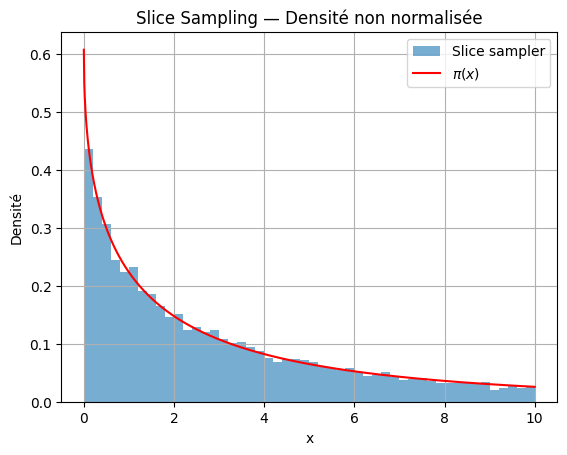

In [23]:
if __name__ == "__main__":
    domain=(0.0, 10.0)
    init_x=1.0
    n_samples = 10000
    samples = slice_sampler(init_x, n_samples, domain)

    # Tracer histogramme + densité
    x_vals = np.linspace(0, 10, 1000)
    density = unnormalized_pi(x_vals)
    density /= np.trapz(density, x_vals)  # normalisation pour affichage

    plt.hist(samples, bins=50, density=True, alpha=0.6, label="Slice sampler")
    plt.plot(x_vals, density, 'r-', label=r"$\pi(x)$")
    plt.title("Slice Sampling — Densité non normalisée")
    plt.xlabel("x")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

## Coupling of the simple Slice sampler

### 1- Coupling from the Past (CFTP) of the slice sampler

In [20]:

def single_step(x, e, W):
    """
    Implements f(x, (e, W)) = x' cf Section 4.
    """
    u = e * unnormalized_pi(x)
    for wj in W:
        if unnormalized_pi(wj) > u:
            return wj
    raise RuntimeError("Did not find an acceptable W_j")

def generate_W_sequence(W_sample_size):
    w0 = np.random.uniform(0,10)
    W = [w0]

    for _ in range(W_sample_size-1):
        w_new = np.random.uniform(0, W[-1])
        W.append(w_new)
    return W



In [21]:

def CFTP_SS(max_iterations, W_sample_size):
    """
    Implements CFTP with a stochastic recursive sequence (Section 4)
    """
    xmin = 0
    xmax = 10

    T = 1

    e_seq = [np.random.uniform(0, 1) for _ in range(max_iterations)]
    w_seq = [generate_W_sequence(W_sample_size) for _ in range(max_iterations)]
    while T <= max_iterations:
        

        x_lower = xmin
        x_upper = xmax

        for i in reversed(range(T)):
            x_lower = single_step(x_lower, e_seq[i], w_seq[i])
            x_upper = single_step(x_upper, e_seq[i], w_seq[i])

        if np.isclose(x_lower, x_upper, atol=1e-8):
            return x_lower  # Perfect sample from pi(x)
        else:
            T *= 2

    raise RuntimeError("CFTP failed to coalesce within max_iterations")



<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\keteb\AppData\Local\Temp\ipykernel_14976\480223952.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
100%|██████████| 1000/1000 [01:27<00:00, 11.48it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_14976\480223952.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)  # display with normalization


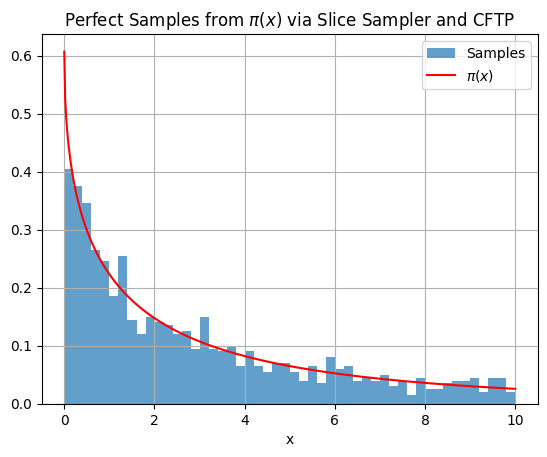

In [22]:
if __name__ == "__main__":
    max_iterations=2**5
    W_sample_size=1000
    samples = [CFTP_SS(max_iterations, W_sample_size) for _ in tqdm(range(1000))]
    
    import matplotlib.pyplot as plt
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples')
    
    x_vals = np.linspace(0, 10, 500)
    density = unnormalized_pi(x_vals)
    density /= np.trapz(density, x_vals)  # display with normalization

    plt.plot(x_vals, density, label=r'$\pi(x)$', color='red')

    plt.legend()
    plt.grid()
    plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
    plt.xlabel("x")
    plt.show()

### CFTP with lower process 
- $\pi(x) = \frac{e^{-x}}{1+x}$ and $\pi^{lb}(x) = e^{-qx},\, q\in (0, 1)$ 